In [1]:
import bw2io as bi
import bw2calc as bc
import bw2data as bd
import pandas as pd
import numpy as np

In [2]:
PROJECT_NAME = "DdS_textile"
TAR_PATH     = '/etc/data/ecoinvent-3.10-cutoff-bw25.tar.gz'

# If the project already exists, just switch to it,
# otherwise restore from archive and then switch.
if PROJECT_NAME in bd.projects:
    bd.projects.set_current(PROJECT_NAME)
else:
    bi.restore_project_directory(
        fp=TAR_PATH,
        project_name=PROJECT_NAME,
    )
    bd.projects.set_current(PROJECT_NAME)


In [3]:
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	fiber_combustion

In Life Cycle Assessment (LCA), the "avoided burden" approach gives credit to a system when it produces outputs that replace products made elsewhere. For example, if a waste management system recovers textiles and turns them into recycled fibers that can replace virgin textiles, the environmental impacts of producing the virgin textiles are subtracted from the system's total footprint. This reflects the environmental benefit of recycling by showing how the system helps avoid emissions and resource use that would have occurred in traditional textile production.

In [4]:
def get_unique_node(name, location, unit, reference_product, database="ecoinvent-3.10-cutoff"):
    matches = [
        act for act in bd.Database(database)
        if act.get('name') == name
        and act.get('location') == location
        and act.get('unit') == unit
        and act.get('reference product') == reference_product
    ]
    
    if len(matches) == 0:
        raise ValueError(f"No match found for: {name} - {location} - {unit} - {reference_product}")
    elif len(matches) == 1:
        return matches[0]
    elif len(matches) > 1:
        raise ValueError(f"Multiple matches found for: {name} - {location} - {unit} - {reference_product}")

avoided_fiber_production_processes = {
    "acrylic": get_unique_node("acrylic acid production", "RER", "kilogram", "acrylic acid"), 
    "cotton": get_unique_node("fibre production, cotton, ginning", "RoW", "kilogram", "fibre, cotton"),
    "polyester": get_unique_node("polyester fibre production, finished", "RoW", "kilogram", "fibre, polyester"),
    "viscose": get_unique_node("fibre production, viscose", "GLO", "kilogram", "fibre, viscose"),
    "silk": get_unique_node("market for fibre, silk, short", "GLO", "kilogram", "fibre, silk, short"),
    "polyamide/nylon": get_unique_node("nylon 6-6 production", "RoW", "kilogram", "nylon 6-6"),
    "wool": get_unique_node("sheep production, for wool", "US", "kilogram", "sheep fleece in the grease"),
}
avoided_fiber_production_processes

{'acrylic': 'acrylic acid production' (kilogram, RER, None),
 'cotton': 'fibre production, cotton, ginning' (kilogram, RoW, None),
 'polyester': 'polyester fibre production, finished' (kilogram, RoW, None),
 'viscose': 'fibre production, viscose' (kilogram, GLO, None),
 'silk': 'market for fibre, silk, short' (kilogram, GLO, None),
 'polyamide/nylon': 'nylon 6-6 production' (kilogram, RoW, None),
 'wool': 'sheep production, for wool' (kilogram, US, None)}

# Basic Combustion Model Summary for Common Textile Fibers

| **Fiber**           | **Chemical Nature**         | **Repeat Unit Formula** | **Molar Mass (g/mol)** | **Notable Combustion Products**       | **HHV (MJ/kg)** |
|---------------------|-----------------------------|--------------------------|------------------------|----------------------------------------|-----------------|
| **Cotton**          | Natural cellulose           | C₆H₁₀O₅                 | 162                    | CO₂, H₂O                               | ~17             |
| **Wool**            | Natural protein (keratin)   | C₂H₅NO + trace S         | ~75                   | CO₂, H₂O, NOₓ, SO₂                      | ~23             |
| **Silk**            | Natural protein (fibroin)   | C₁₅H₂₀N₅O₆              | 365                    | CO₂, H₂O, NOₓ                           | ~20             |
| **Viscose**         | Regenerated cellulose       | C₆H₁₀O₅                 | 162                    | CO₂, H₂O                               | ~16             |
| **Polyester (PET)** | Synthetic polymer           | C₁₀H₈O₄                 | 192                    | CO₂, H₂O, CO, soot                      | ~24             |
| **Polyamide/Nylon** | Synthetic polymer           | C₁₂H₂₂N₂O₂              | 226                    | CO₂, H₂O, NOₓ                           | ~30             |
| **Acrylic (PAN)**   | Synthetic polymer           | C₃H₃N                   | 53                     | CO₂, H₂O, HCN                           | ~28             |
                      |

> Notes:
> - All combustion reactions assume **complete oxidation**.
> - **Nitrogen-containing** fibers release NOₓ (e.g. wool, silk, nylon).
> - **Sulfur-containing** fibers (e.g. wool) produce SO₂.
> - **Acrylic** releases **hydrogen cyanide (HCN)** upon burning.
> - Higher heating value approximated based on literature values / chemical composition


In [5]:
from dataclasses import dataclass
from typing import Dict
import pprint
import bw2data as bd

@dataclass
class Fiber:
    name: str
    formula: Dict[str, int]  # Elemental composition per repeat unit
    molar_mass: float        # g/mol
    byproducts: Dict[str, int]  # Special combustion byproducts like HCN, SO2, NOx

# Define fibers
fibers = [
    Fiber("Cotton", {"C":6, "H":10, "O":5}, 162, {}),
    Fiber("Wool", {"C":2, "H":5, "O":1, "N":1, "S":0.05}, 75, {"SO2": 0.05, "NOx": 1}),
    Fiber("Silk", {"C":15, "H":20, "O":6, "N":5}, 365, {"NOx": 5}),
    Fiber("Viscose", {"C":6, "H":10, "O":5}, 162, {}),
    Fiber("Polyester", {"C":10, "H":8, "O":4}, 192, {}),
    Fiber("Polyamide/Nylon", {"C":12, "H":22, "O":2, "N":2}, 226, {"NOx": 2}),
    Fiber("Acrylic", {"C":3, "H":3, "N":1}, 53, {"HCN": 1}),
]

# Molar masses
atomic_weights = {
    "C": 12.01,
    "H": 1.008,
    "O": 16.00,
    "N": 14.01,
    "S": 32.06,
    "CO2": 44.01,
    "H2O": 18.02,
    "SO2": 64.06,
    "NOx": 46.00,  # Approx for NO2
    "HCN": 27.03,
}

def combustion_products(fiber: Fiber):
    moles = 1000 / fiber.molar_mass  # 1 kg of fiber
    products = {}

    # CO2: 1 per C atom
    if "C" in fiber.formula:
        products["CO2"] = moles * fiber.formula["C"]

    # H2O: 0.5 per H atom
    if "H" in fiber.formula:
        products["H2O"] = moles * fiber.formula["H"] / 2

    # NOx, SO2, HCN etc.
    for gas, count in fiber.byproducts.items():
        products[gas] = moles * count

    # Convert to mass (g)
    products_mass = {gas: round(mol * atomic_weights[gas] / 1000, 3) for gas, mol in products.items()}  # in kg

    return products_mass

# Display results
for fiber in fibers:
    mass_output = combustion_products(fiber)
    print(f"\n Combustion products from 1 kg of {fiber.name}:")
    pprint.pprint(mass_output)



 Combustion products from 1 kg of Cotton:
{'CO2': 1.63, 'H2O': 0.556}

 Combustion products from 1 kg of Wool:
{'CO2': 1.174, 'H2O': 0.601, 'NOx': 0.613, 'SO2': 0.043}

 Combustion products from 1 kg of Silk:
{'CO2': 1.809, 'H2O': 0.494, 'NOx': 0.63}

 Combustion products from 1 kg of Viscose:
{'CO2': 1.63, 'H2O': 0.556}

 Combustion products from 1 kg of Polyester:
{'CO2': 2.292, 'H2O': 0.375}

 Combustion products from 1 kg of Polyamide/Nylon:
{'CO2': 2.337, 'H2O': 0.877, 'NOx': 0.407}

 Combustion products from 1 kg of Acrylic:
{'CO2': 2.491, 'H2O': 0.51, 'HCN': 0.51}


In [6]:
def get_biosphere_flow(name, unit=None, categories=None, database="ecoinvent-3.10-biosphere"):
    matches = [
        flow for flow in bd.Database(database)
        if flow.get('name') == name
        and (unit is None or flow.get('unit') == unit)
        and (categories is None or flow.get('categories') == categories)
    ]

    if len(matches) == 0:
        raise ValueError(f" No biosphere flow found for: {name} - {unit} - {categories}")
    elif len(matches) == 1:
        return matches[0]
    else:
        print(f"⚠️ Multiple matches found for: {name}")
        for i, match in enumerate(matches):
            print(f"  Match {i+1}: {match['name']} | {match.get('unit')} | {match.get('categories')}")
        raise ValueError(" Too many matches. Refine your query.")
    
element_flows = {
    "H2O": get_biosphere_flow("Water, in air", "cubic meter", ("natural resource", "in air")),
    "CO2": get_biosphere_flow("Carbon dioxide, fossil", "kilogram", ("air",)),
    "NOx": get_biosphere_flow("Nitrogen oxides", "kilogram", ("air",)),
    "SO2": get_biosphere_flow("Sulfur dioxide", "kilogram", ("air",)),
    "CO": get_biosphere_flow("Carbon monoxide, fossil", "kilogram", ("air",)),
    "HCN": get_biosphere_flow("Hydrogen cyanide", "kilogram", ("air",)),
}
element_flows

{'H2O': 'Water, in air' (cubic meter, None, ('natural resource', 'in air')),
 'CO2': 'Carbon dioxide, fossil' (kilogram, None, ('air',)),
 'NOx': 'Nitrogen oxides' (kilogram, None, ('air',)),
 'SO2': 'Sulfur dioxide' (kilogram, None, ('air',)),
 'CO': 'Carbon monoxide, fossil' (kilogram, None, ('air',)),
 'HCN': 'Hydrogen cyanide' (kilogram, None, ('air',))}

In [8]:
if "fiber_combustion" in bd.databases:
    del bd.databases["fiber_combustion"]
    print("⚠️ Deleted existing 'fiber_combustion' database.")
fiber_db = bd.Database("fiber_combustion")
activity_data = {}

for fiber in fibers:
    outputs = combustion_products(fiber)

    exchanges = []
    for elem, amount in outputs.items():
        flow = element_flows.get(elem)
        if not flow:
            print(f"⚠️ {elem} not found — skipping in {fiber.name}")
            continue
        exchanges.append({
            'input': flow.key,
            'amount': amount,
            'type': 'biosphere',
            'unit': flow['unit'],
            'name': flow['name'],
        })

    exchanges.append({
        'input': ("fiber_combustion", f"{fiber.name.lower()}_combustion"),
        'amount': 1.0,
        'type': 'production',
        'unit': "kilogram",
        'name': f"Combustion of {fiber.name}",
    })

    activity_data[("fiber_combustion", f"{fiber.name.lower()}_combustion")] = {
        'name': f"Combustion of {fiber.name}",
        'unit': "kilogram",
        'exchanges': exchanges,
    }

fiber_db.write(activity_data)
print("✅ Regenerated all activities with updated flows.")

⚠️ Deleted existing 'fiber_combustion' database.
13:22:28+0800 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 7/7 [00:00<00:00, 1117.29it/s]


13:22:28+0800 [info     ] Vacuuming database            
✅ Regenerated all activities with updated flows.


In [9]:
fiber_incineration = {
    fiber.name.lower(): bd.get_activity(("fiber_combustion", f"{fiber.name.lower()}_combustion"))
    for fiber in fibers
}
fiber_incineration


{'cotton': 'Combustion of Cotton' (kilogram, None, None),
 'wool': 'Combustion of Wool' (kilogram, None, None),
 'silk': 'Combustion of Silk' (kilogram, None, None),
 'viscose': 'Combustion of Viscose' (kilogram, None, None),
 'polyester': 'Combustion of Polyester' (kilogram, None, None),
 'polyamide/nylon': 'Combustion of Polyamide/Nylon' (kilogram, None, None),
 'acrylic': 'Combustion of Acrylic' (kilogram, None, None)}

In [10]:

methods = {
    "acidification": (
        'ecoinvent-3.10', 'EF v3.1 no LT',
        'acidification no LT', 'accumulated exceedance (AE) no LT'
    ),
    "climate change": (
        'ecoinvent-3.10', 'EF v3.1 no LT',
        'climate change no LT', 'global warming potential (GWP100) no LT'
    ),
    "ecotoxicity": (
        'ecoinvent-3.10', 'EF v3.1 no LT',
        'ecotoxicity: freshwater no LT', 'comparative toxic unit for ecosystems (CTUe) no LT'
    ),
    # "fossil depletion": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'energy resources: non-renewable no LT', 'abiotic depletion potential (ADP): fossil fuels no LT'
    # ),
    # "eutrophication freshwater": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'eutrophication: freshwater no LT', 'fraction of nutrients reaching freshwater end compartment (P) no LT'
    # ),
    # "human toxicity carcinogenic": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'human toxicity: carcinogenic no LT', 'comparative toxic unit for human (CTUh) no LT'
    # ),
    # "human toxicity non-carcinogenic": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'human toxicity: non-carcinogenic no LT', 'comparative toxic unit for human (CTUh) no LT'
    # ),
    # "ionising radiation": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'ionising radiation: human health no LT', 'human exposure efficiency relative to u235 no LT'
    # ),
    # "land use": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'land use no LT', 'soil quality index no LT'
    # ),
    # "metal depletion": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'material resources: metals/minerals no LT', 'abiotic depletion potential (ADP): elements (ultimate reserves) no LT'
    # ),
    # "ozone depletion": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'ozone depletion no LT', 'ozone depletion potential (ODP) no LT'
    # ),
    # "particulate matter": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'particulate matter formation no LT', 'impact on human health no LT'
    # ),
    # "smog formation": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'photochemical oxidant formation: human health no LT', 'tropospheric ozone concentration increase no LT'
    # ),
    # "water use": (
    #     'ecoinvent-3.10', 'EF v3.1 no LT',
    #     'water use no LT', 'user deprivation potential (deprivation-weighted water consumption) no LT'
    # ),
}
results = np.zeros((len(fiber_incineration), len(methods)))
products = list(fiber_incineration.values())

for i, product in enumerate(products):
    for j, method in enumerate(methods.values()):
        lca = bc.LCA({product: 1}, method=method)
        lca.lci()
        lca.lcia()
        results[i, j] = lca.score

df_results = pd.DataFrame(
    results,
    index=[p['name'] for p in products],
    columns=methods.keys()
)

df_results = df_results.loc[:, (df_results != 0).any(axis=0)]
display(df_results)


,acidification,climate change,ecotoxicity
Combustion of Cotton,0.00000,1.630,0.000000
Combustion of Wool,0.50995,1.174,0.000000
Combustion of Silk,0.46620,1.809,0.000000
Combustion of Viscose,0.00000,1.630,0.000000
Combustion of Polyester,0.00000,2.292,0.000000
Combustion of Polyamide/Nylon,0.30118,2.337,0.000000
Combustion of Acrylic,0.00000,2.491,1199.774978


In [11]:
avoided_fiber_production_processes

{'acrylic': 'acrylic acid production' (kilogram, RER, None),
 'cotton': 'fibre production, cotton, ginning' (kilogram, RoW, None),
 'polyester': 'polyester fibre production, finished' (kilogram, RoW, None),
 'viscose': 'fibre production, viscose' (kilogram, GLO, None),
 'silk': 'market for fibre, silk, short' (kilogram, GLO, None),
 'polyamide/nylon': 'nylon 6-6 production' (kilogram, RoW, None),
 'wool': 'sheep production, for wool' (kilogram, US, None)}

In [12]:
def conduct_fiber_lca(fiber_masses, incineration_acts, recycling_acts, methods):
    """
    Conducts fiber LCA with standard bw2 LCA (no MultiLCA).

    Parameters:
        fiber_masses: dict of {fiber name: mass in kg}
        incineration_acts: dict of {fiber name: bw2 activity}
        recycling_acts: dict of {fiber name (lowercase): bw2 activity}
        methods: dict of {method name: method tuple}

    Returns:
        pd.DataFrame of net impacts (incineration - avoided burden)
    """
    fibers = list(fiber_masses.keys())
    method_keys = list(methods.keys())
    results = np.zeros((len(fibers), len(methods)))

    for i, fiber in enumerate(fibers):
        inc_activity = incineration_acts[fiber]
        rec_activity = recycling_acts[fiber.lower()]
        amount = fiber_masses[fiber]

        for j, method in enumerate(methods.values()):
            # Incineration impact
            lca_inc = bc.LCA({inc_activity: amount}, method=method)
            lca_inc.lci()
            lca_inc.lcia()
            inc_score = lca_inc.score

            # Avoided burden (negative)
            lca_rec = bc.LCA({rec_activity: amount}, method=method)
            lca_rec.lci()
            lca_rec.lcia()
            rec_score = lca_rec.score

            # Net score: incineration - recycling (i.e. actual impact)
            results[i, j] = inc_score - rec_score

    return pd.DataFrame(results, index=fibers, columns=method_keys)


In [13]:
def conduct_fiber_lca_efficient(fiber_masses, incineration_acts, recycling_acts, methods):
    """
    Efficient LCA for multiple methods using shared LCI and switching LCIA matrices.

    Parameters:
        fiber_masses: dict of {fiber name: mass in kg}
        incineration_acts: dict of {fiber name: bw2 activity}
        recycling_acts: dict of {fiber name (lowercase): bw2 activity}
        methods: dict of {method label: method tuple}

    Returns:
        pd.DataFrame of net impacts (incineration - recycling)
    """
    fibers = list(fiber_masses.keys())
    method_labels = list(methods.keys())
    method_tuples = list(methods.values())

    # Initialize result array
    results = np.zeros((len(fibers), len(methods)))

    # Prepare LCA object (any activity works for initialization)
    dummy_product = list(incineration_acts.values())[0]
    lca = bc.LCA({dummy_product: 1}, method_tuples[0])
    lca.lci()
    lca.lcia()

    # Cache all method characterization matrices
    char_matrices = []
    for method in method_tuples:
        lca.switch_method(method)
        char_matrices.append(lca.characterization_matrix.copy())

    # Loop over fibers
    for i, fiber in enumerate(fibers):
        mass = fiber_masses[fiber]
        inc_act = incineration_acts[fiber]
        rec_act = recycling_acts[fiber.lower()]
        inc_prod = [exc for exc in inc_act.exchanges() if exc['type'] == 'production'][0]
        rec_prod = [exc for exc in rec_act.exchanges() if exc['type'] == 'production'][0]


        # Build inventory once for incineration and once for recycling
        lca.lci({inc_prod.input.id: mass})
        inc_inv = lca.inventory.copy()
        lca.lci({rec_prod.input.id: mass})
        rec_inv = lca.inventory.copy()

        # Net impact = incineration - avoided recycling
        for j, char_matrix in enumerate(char_matrices):
            inc_score = (char_matrix * inc_inv).sum()
            rec_score = (char_matrix * rec_inv).sum()
            results[i, j] = inc_score - rec_score

    # Return as DataFrame
    return pd.DataFrame(results, index=fibers, columns=method_labels)


In [16]:
# Define fiber masses for each scenario
fiber_masses_scenarios = {
    "long life": {
        "acrylic": 165.8394646,
        "cotton": 2918.318368,
        "polyamide/nylon": 290.1415923,
        "polyester": 5222.04837,
        "silk": 59.61657397,
        "viscose": 26.96180028,
        "wool": 191.8321327,
    },
    "original": {
        "acrylic": 1190.83234,
        "cotton": 11920.45104,
        "polyamide/nylon": 1313.978388,
        "polyester": 15581.79104,
        "silk": 419.3447865,
        "viscose": 204.4524576,
        "wool": 1356.474823,
    },
    "high recycling": {
        "acrylic": 1658.936956,
        "cotton": 16595.43447,
        "polyamide/nylon": 1829.193763,
        "polyester": 21677.58646,
        "silk": 584.190478,
        "viscose": 284.8328827,
        "wool": 1889.713735,
    }
}

# Run LCA for each scenario and store results
lca_results_scenarios = {}

for scenario, fiber_masses in fiber_masses_scenarios.items():
    lca_results_scenarios[scenario] = conduct_fiber_lca(
        fiber_masses=fiber_masses,
        incineration_acts=fiber_incineration,
        recycling_acts=avoided_fiber_production_processes,
        methods=methods
    )

# Optionally display results for each scenario
for scenario, df in lca_results_scenarios.items():
    print(f"\nScenario: {scenario}")
    display(df)
    # Export results to CSV
    df.to_csv(f"fiber_lca_{scenario.replace(' ', '_')}.csv")


Scenario: long life


,acidification,climate change,ecotoxicity
acrylic,-1.268505,-20.236950,197266.104557
cotton,-129.234680,-1583.934424,-916867.100853
polyamide/nylon,77.082309,-1709.712497,-2443.049118
polyester,-112.818086,-14179.783208,-131350.505883
silk,27.790359,107.212217,-4.231307
viscose,-0.940049,-46.478322,-514.356979
wool,-127.621897,-8013.667068,-50503.077294



Scenario: original


,acidification,climate change,ecotoxicity
acrylic,-9.108669,-145.314108,1.416496e+06
cotton,-527.884722,-6469.894773,-3.745126e+06
polyamide/nylon,349.086414,-7742.858417,-1.106396e+04
polyester,-336.631856,-42310.297278,-3.919298e+05
silk,195.478223,754.133981,-2.976314e+01
viscose,-7.128434,-352.447059,-3.900390e+03
wool,-902.434266,-56665.885246,-3.571151e+05



Scenario: high recycling


,acidification,climate change,ecotoxicity
acrylic,-12.689198,-202.435672,1.973306e+06
cotton,-734.911480,-9007.269472,-5.213896e+06
polyamide/nylon,485.964379,-10778.859420,-1.540217e+04
polyester,-468.326533,-58862.625292,-5.452577e+05
silk,272.321298,1050.586308,-4.146312e+01
viscose,-9.930976,-491.011519,-5.433828e+03
wool,-1257.186936,-78941.606464,-4.974993e+05


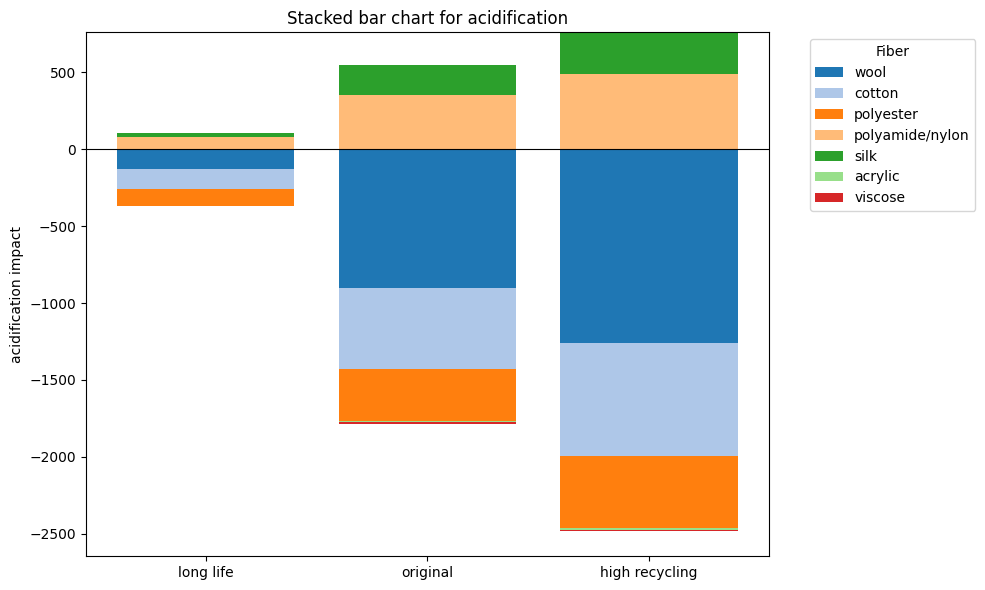

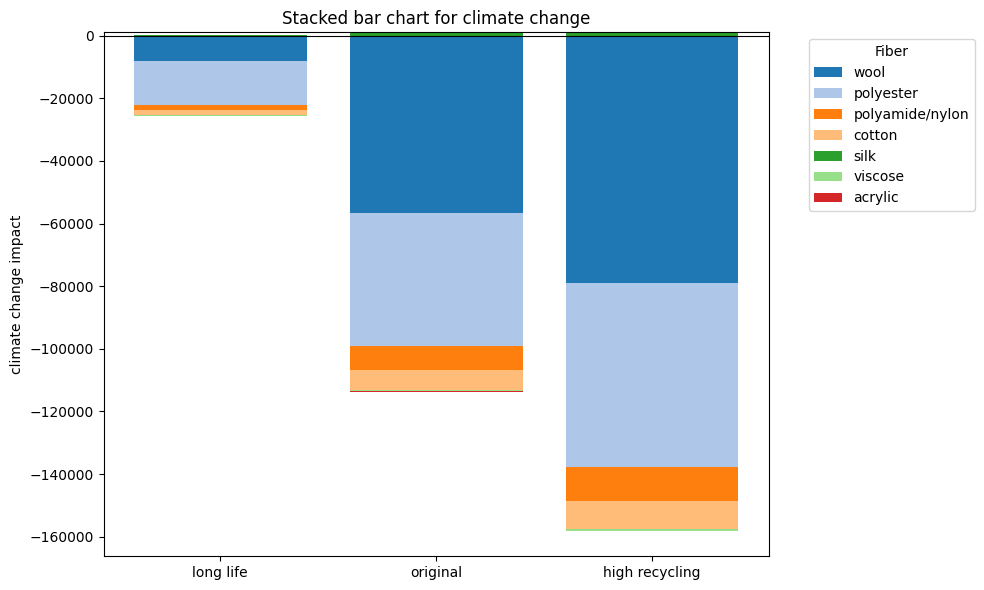

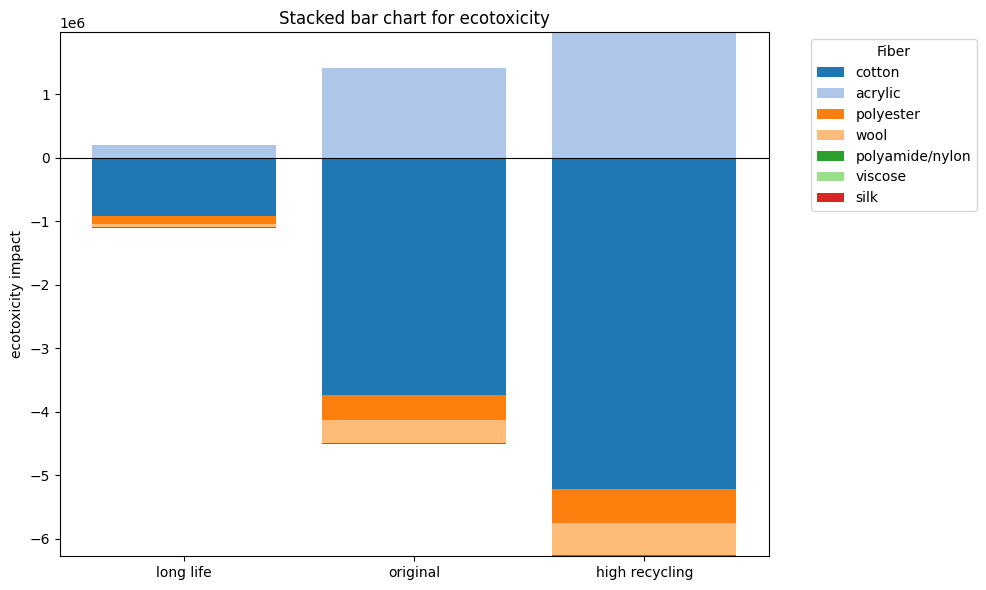

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

colors = plt.cm.tab20.colors
scenarios = list(lca_results_scenarios.keys())
impact_categories = lca_results_scenarios[scenarios[0]].columns.tolist()
fibers = lca_results_scenarios[scenarios[0]].index.tolist()

for category in impact_categories:
    # Build a category_df with fibers as rows and scenarios as columns
    category_df = pd.DataFrame(index=fibers, columns=scenarios)

    for scenario, df in lca_results_scenarios.items():
        category_df[scenario] = df[category]

    # Sort fibers by mean absolute value across all scenarios for this category
    mean_abs = category_df.abs().mean(axis=1)
    sorted_fibers = mean_abs.sort_values(ascending=False).index.tolist()
    category_df = category_df.loc[sorted_fibers]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    pos_bottom = np.zeros(len(scenarios))
    neg_bottom = np.zeros(len(scenarios))

    for i, fiber in enumerate(category_df.index):
        values = category_df.loc[fiber].values.astype(float)
        pos_values = np.where(values > 0, values, 0)
        neg_values = np.where(values < 0, values, 0)

        # Positive stack
        ax.bar(scenarios, pos_values, bottom=pos_bottom, label=fiber if any(pos_values) else "", color=colors[i % len(colors)])
        pos_bottom += pos_values

        # Negative stack
        ax.bar(scenarios, neg_values, bottom=neg_bottom, label=fiber if any(neg_values) else "", color=colors[i % len(colors)])
        neg_bottom += neg_values

    ax.set_title(f"Stacked bar chart for {category}")
    ax.set_ylabel(f"{category} impact")
    ax.axhline(0, color='black', linewidth=0.8)
    ax.legend(title="Fiber", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


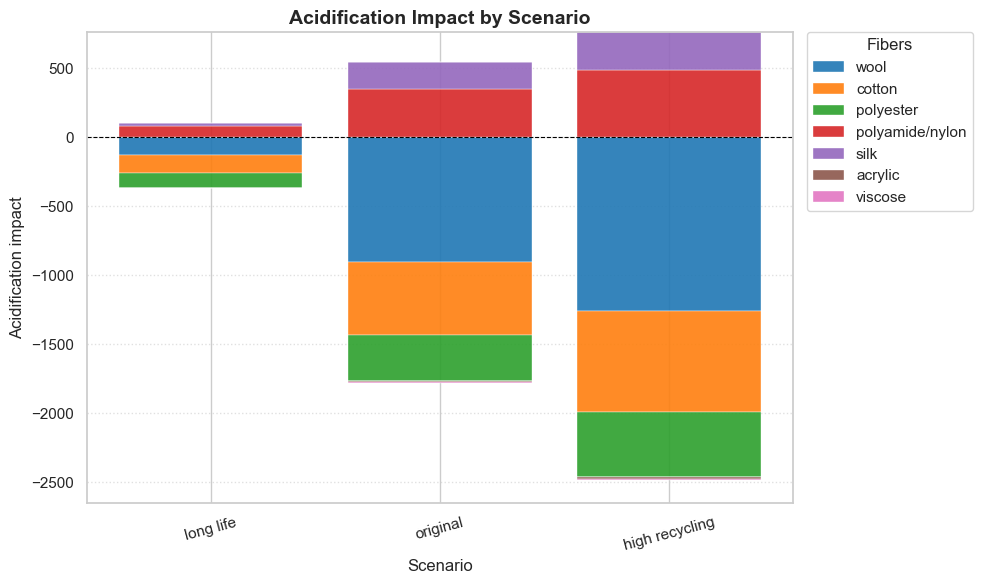

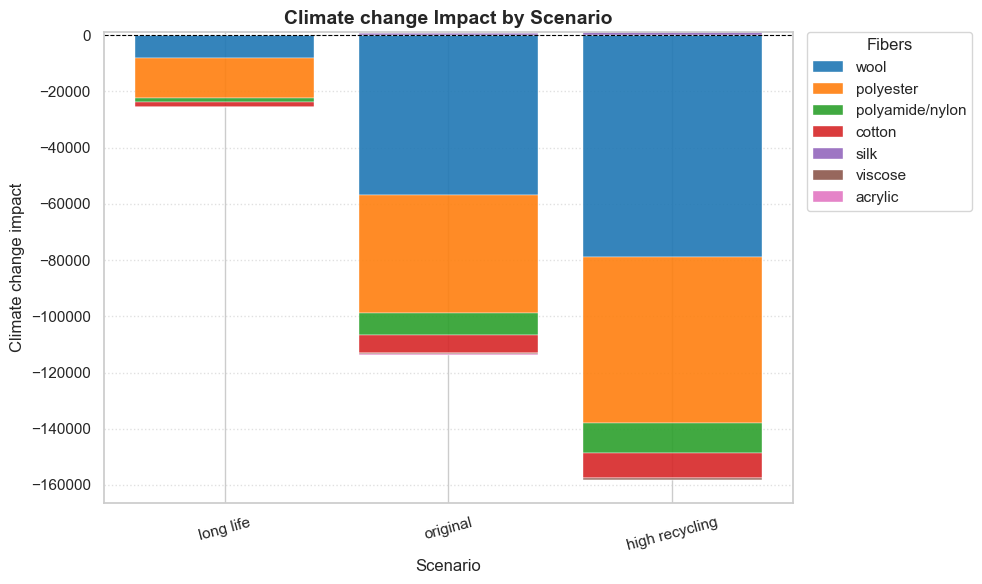

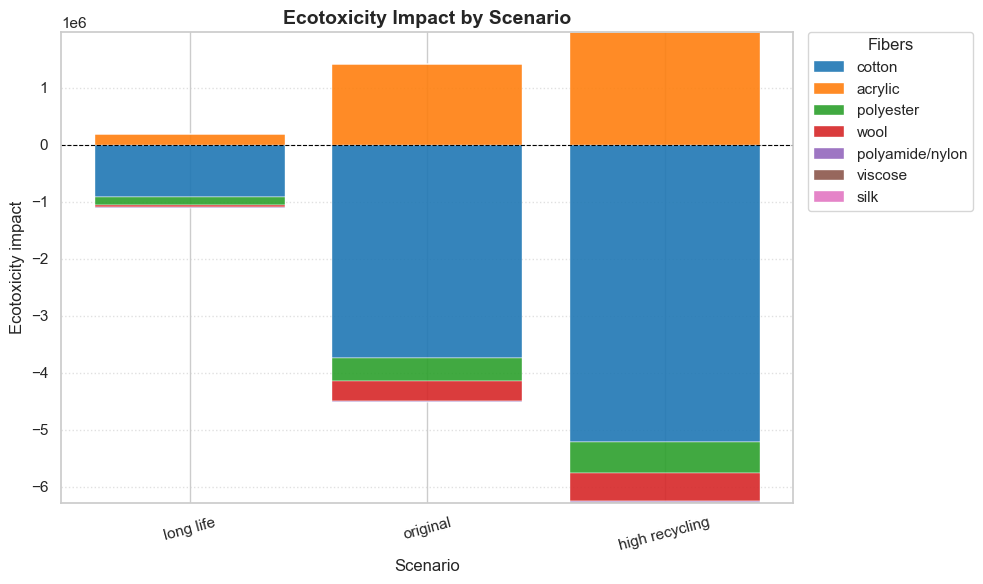

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style="whitegrid")
colors = sns.color_palette("tab10", n_colors=10)  # More vibrant

scenarios = list(lca_results_scenarios.keys())
impact_categories = lca_results_scenarios[scenarios[0]].columns.tolist()
fibers = lca_results_scenarios[scenarios[0]].index.tolist()

for category in impact_categories:
    # Build the data
    category_df = pd.DataFrame(index=fibers, columns=scenarios)
    for scenario, df in lca_results_scenarios.items():
        category_df[scenario] = df[category]

    # Sort fibers by mean absolute value
    mean_abs = category_df.abs().mean(axis=1)
    sorted_fibers = mean_abs.sort_values(ascending=False).index.tolist()
    category_df = category_df.loc[sorted_fibers]

    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pos_bottom = np.zeros(len(scenarios))
    neg_bottom = np.zeros(len(scenarios))

    for i, fiber in enumerate(category_df.index):
        values = category_df.loc[fiber].values.astype(float)
        pos_vals = np.where(values > 0, values, 0)
        neg_vals = np.where(values < 0, values, 0)

        ax.bar(
            scenarios, pos_vals, bottom=pos_bottom, label=fiber,
            color=colors[i % len(colors)], edgecolor='white', linewidth=0.3, alpha=0.9
        )
        pos_bottom += pos_vals

        ax.bar(
            scenarios, neg_vals, bottom=neg_bottom,
            color=colors[i % len(colors)], edgecolor='white', linewidth=0.3, alpha=0.9
        )
        neg_bottom += neg_vals

    # Add formatting
    ax.set_title(f"{category.capitalize()} Impact by Scenario", fontsize=14, weight='bold')
    ax.set_ylabel(f"{category.capitalize()} impact", fontsize=12)
    ax.set_xlabel("Scenario", fontsize=12)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.grid(True, axis='y', linestyle=':', alpha=0.6)

    # Manage legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), title="Fibers", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
